数据描述：

Columns:
* index: DataFrame的索引。
* A_id: 物品的ID。
* Size: 物品的尺寸，以某种计量单位表示。
* Weight: 物品的重量，以某种计量单位表示。
* Sweetness: 物品的甜度水平，以从非常甜到非常酸的比例表示。
* Crunchiness: 物品的脆度水平，以从非常软到非常脆的比例表示。
* Juiciness: 物品的多汁程度，以从非常干燥到非常多汁的比例表示。
* Ripeness: 物品的成熟程度，以从未成熟到过熟的比例表示。
* Acidity: 物品的酸度水平，以从非常低到非常高的比例表示。
* Quality: 物品的整体质量评级，可为“好”或“坏”。

## 1. 导入必要的库

In [90]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from scipy import stats
from colorama import Fore, init
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.model_selection import learning_curve


import warnings
warnings.filterwarnings ('ignore')

sns.set(style="whitegrid")


## 2. 导入数据

In [91]:
df = pd.read_csv(r"./apple_quality.csv")

---
头部数据的显示

In [92]:
df.head()

A_id      Size    Weight  Sweetness  Crunchiness  Juiciness  Ripeness  \
0   0.0 -3.970049 -2.512336   5.346330    -1.012009   1.844900  0.329840   
1   1.0 -1.195217 -2.839257   3.664059     1.588232   0.853286  0.867530   
2   2.0 -0.292024 -1.351282  -1.738429    -0.342616   2.838636 -0.038033   
3   3.0 -0.657196 -2.271627   1.324874    -0.097875   3.637970 -3.413761   
4   4.0  1.364217 -1.296612  -0.384658    -0.553006   3.030874 -1.303849   

        Acidity Quality  
0  -0.491590483    good  
1  -0.722809367    good  
2   2.621636473     bad  
3   0.790723217    good  
4   0.501984036    good

In [93]:
# 获取数据的详细信息与解释

In [94]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4001 entries, 0 to 4000
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   A_id         4000 non-null   float64
 1   Size         4000 non-null   float64
 2   Weight       4000 non-null   float64
 3   Sweetness    4000 non-null   float64
 4   Crunchiness  4000 non-null   float64
 5   Juiciness    4000 non-null   float64
 6   Ripeness     4000 non-null   float64
 7   Acidity      4001 non-null   object 
 8   Quality      4000 non-null   object 
dtypes: float64(7), object(2)
memory usage: 281.4+ KB


In [95]:
# 数据的描述

In [96]:
df.describe().T.style.background_gradient(axis=0, cmap='viridis')

In [97]:
# 获得数据集中重复的部分

In [98]:
df.duplicated().sum()

0

In [99]:
# 统计每列数据的内容

In [100]:
for column in df.columns:
    num_distinct_values = len(df[column].unique())
    print(f"{column}: {num_distinct_values} distinct values")

A_id: 4001 distinct values
Size: 4001 distinct values
Weight: 4001 distinct values
Sweetness: 4001 distinct values
Crunchiness: 4001 distinct values
Juiciness: 4001 distinct values
Ripeness: 4001 distinct values
Acidity: 4001 distinct values
Quality: 3 distinct values


In [101]:
df.duplicated().sum()

0

In [102]:
# 筛选出数据集中包含缺失值的行并且进行删除

In [103]:
df[df.isnull().any(axis = 1)]

A_id  Size  Weight  Sweetness  Crunchiness  Juiciness  Ripeness  \
4000   NaN   NaN     NaN        NaN          NaN        NaN       NaN   

                                Acidity Quality  
4000  Created_by_Nidula_Elgiriyewithana     NaN

## 3. 特征工程

### 3.1  数据清洗

In [104]:
def clean_data(df):
    df = df.drop(columns=['A_id']).dropna()
    df['Acidity'] = df['Acidity'].astype(float)
    def label(quality):
        if quality == "good":
            return 0
        if quality == "bad":
            return 1
    df['Label'] = df['Quality'].apply(label)
    df = df.drop(columns=['Quality']).astype({'Label': 'int64'})
    return df
df_clean = clean_data(df.copy())

In [105]:
# 显示删除后的数据

In [106]:
df_clean.head()

Size    Weight  Sweetness  Crunchiness  Juiciness  Ripeness   Acidity  \
0 -3.970049 -2.512336   5.346330    -1.012009   1.844900  0.329840 -0.491590   
1 -1.195217 -2.839257   3.664059     1.588232   0.853286  0.867530 -0.722809   
2 -0.292024 -1.351282  -1.738429    -0.342616   2.838636 -0.038033  2.621636   
3 -0.657196 -2.271627   1.324874    -0.097875   3.637970 -3.413761  0.790723   
4  1.364217 -1.296612  -0.384658    -0.553006   3.030874 -1.303849  0.501984   

   Label  
0      0  
1      0  
2      1  
3      0  
4      0

In [107]:
# 数据的信息的统计与显示

In [108]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4000 entries, 0 to 3999
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Size         4000 non-null   float64
 1   Weight       4000 non-null   float64
 2   Sweetness    4000 non-null   float64
 3   Crunchiness  4000 non-null   float64
 4   Juiciness    4000 non-null   float64
 5   Ripeness     4000 non-null   float64
 6   Acidity      4000 non-null   float64
 7   Label        4000 non-null   int64  
dtypes: float64(7), int64(1)
memory usage: 281.2 KB


### 3.2  可视化

#### 3.2.1  单列图


In [109]:
# 各类特征的柱状图显示
import matplotlib

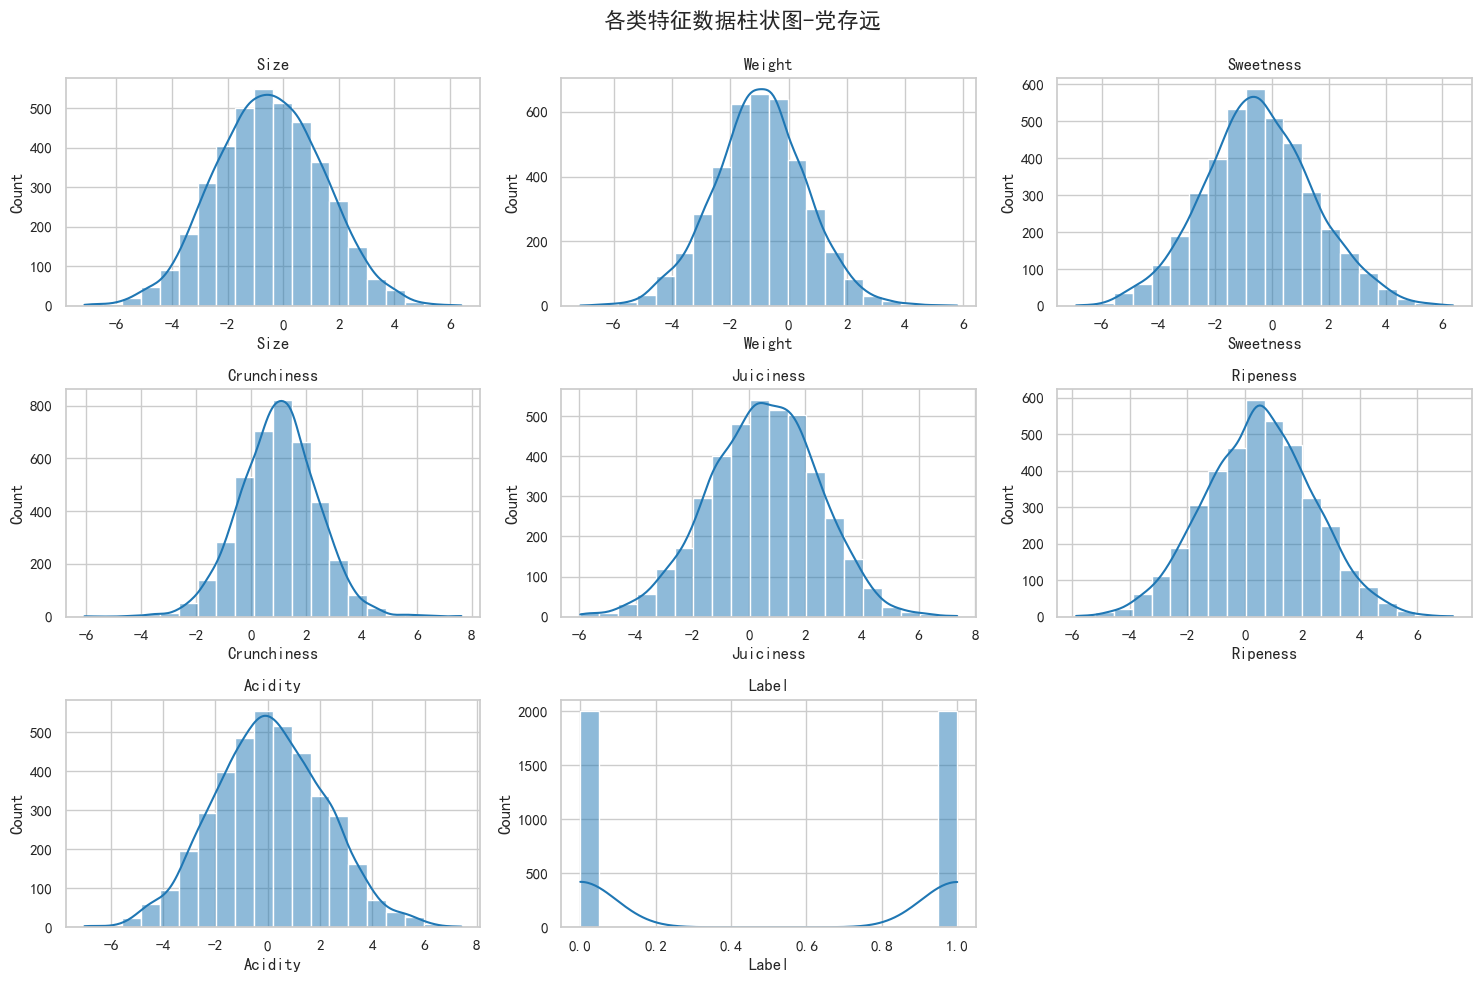

In [110]:
matplotlib.rcParams['font.sans-serif'] = ['SimHei']  
matplotlib.rcParams['axes.unicode_minus'] = False  
numerical_cols = ['Size', 'Weight', 'Sweetness', 'Crunchiness', 'Juiciness', 'Ripeness', 'Acidity', 'Label']

plt.figure(figsize=(15, 10))
sns.set_palette("tab10")

for i, column in enumerate(numerical_cols, 1):
    plt.subplot(3, 3, i)
    sns.histplot(data=df_clean, x=column, kde=True, bins=20)
    plt.title(column)


plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.suptitle('各类特征数据柱状图-党存远', fontsize=16)  
plt.show()

In [111]:
# 显示出数据箱形图

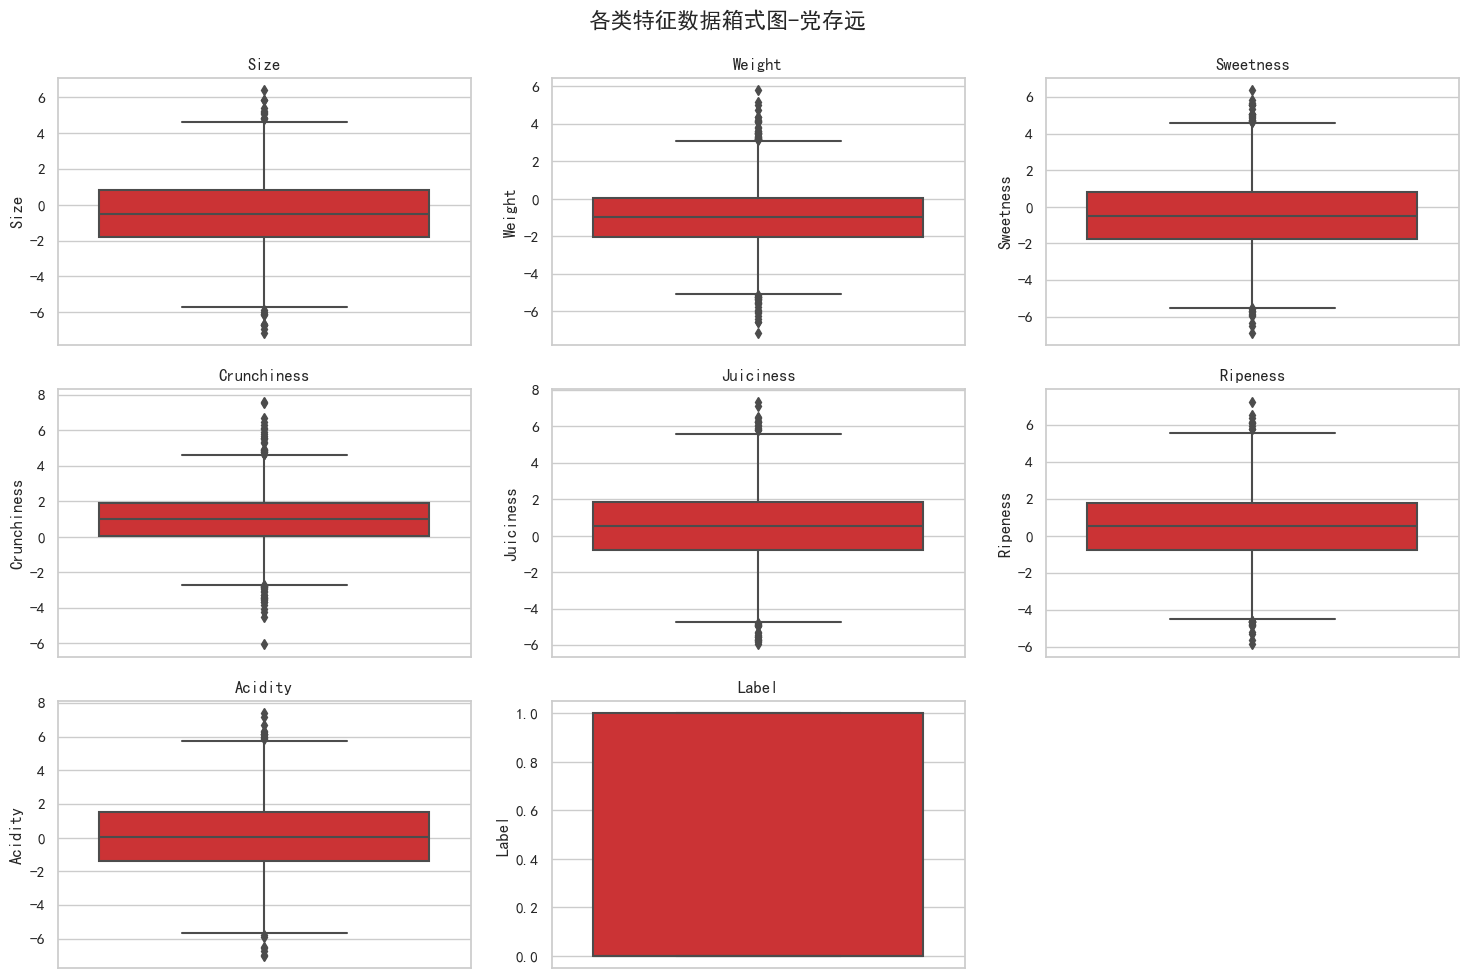

In [112]:
numerical_cols = ['Size', 'Weight', 'Sweetness', 'Crunchiness', 'Juiciness', 'Ripeness', 'Acidity','Label']

plt.figure(figsize=(15, 10))
sns.set_palette("Set1")
for i, column in enumerate(numerical_cols, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(y=df_clean[column])
    plt.title(column)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.suptitle('各类特征数据箱式图-党存远', fontsize=16)  
plt.show()


In [113]:
# 数据散点图

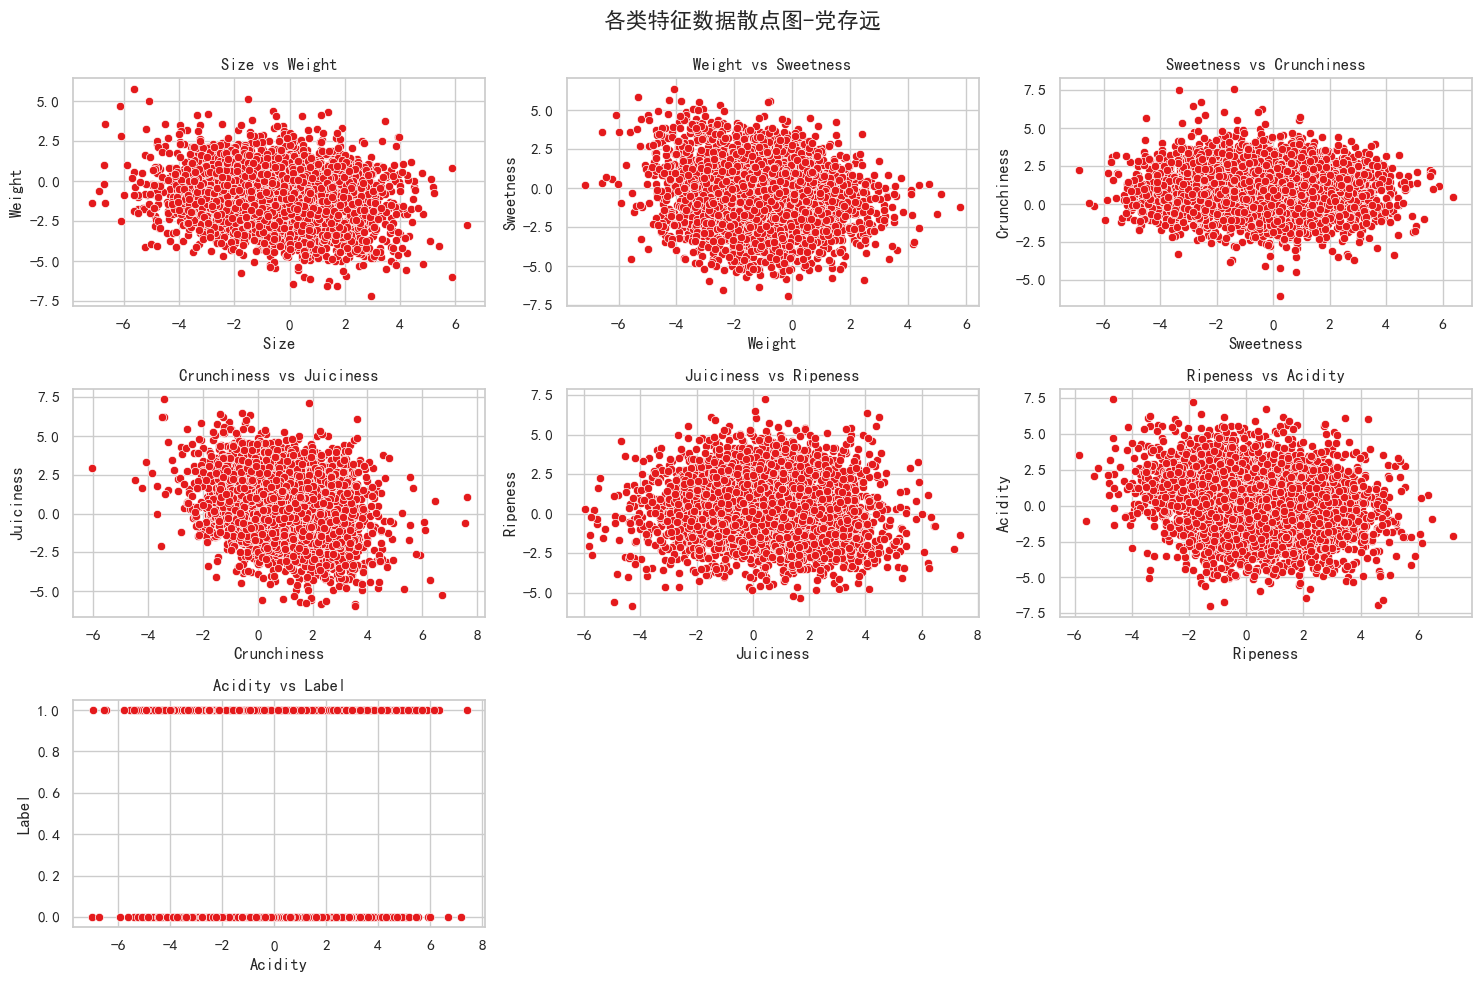

In [114]:
plt.figure(figsize=(15, 10))
for i in range(1, len(numerical_cols)):
    plt.subplot(3, 3, i)
    sns.scatterplot(x=df_clean[numerical_cols[i-1]], y=df_clean[numerical_cols[i]])
    plt.title(f"{numerical_cols[i-1]} vs {numerical_cols[i]}")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.suptitle('各类特征数据散点图-党存远', fontsize=16)  
plt.show()

In [115]:
# 数据小提琴图

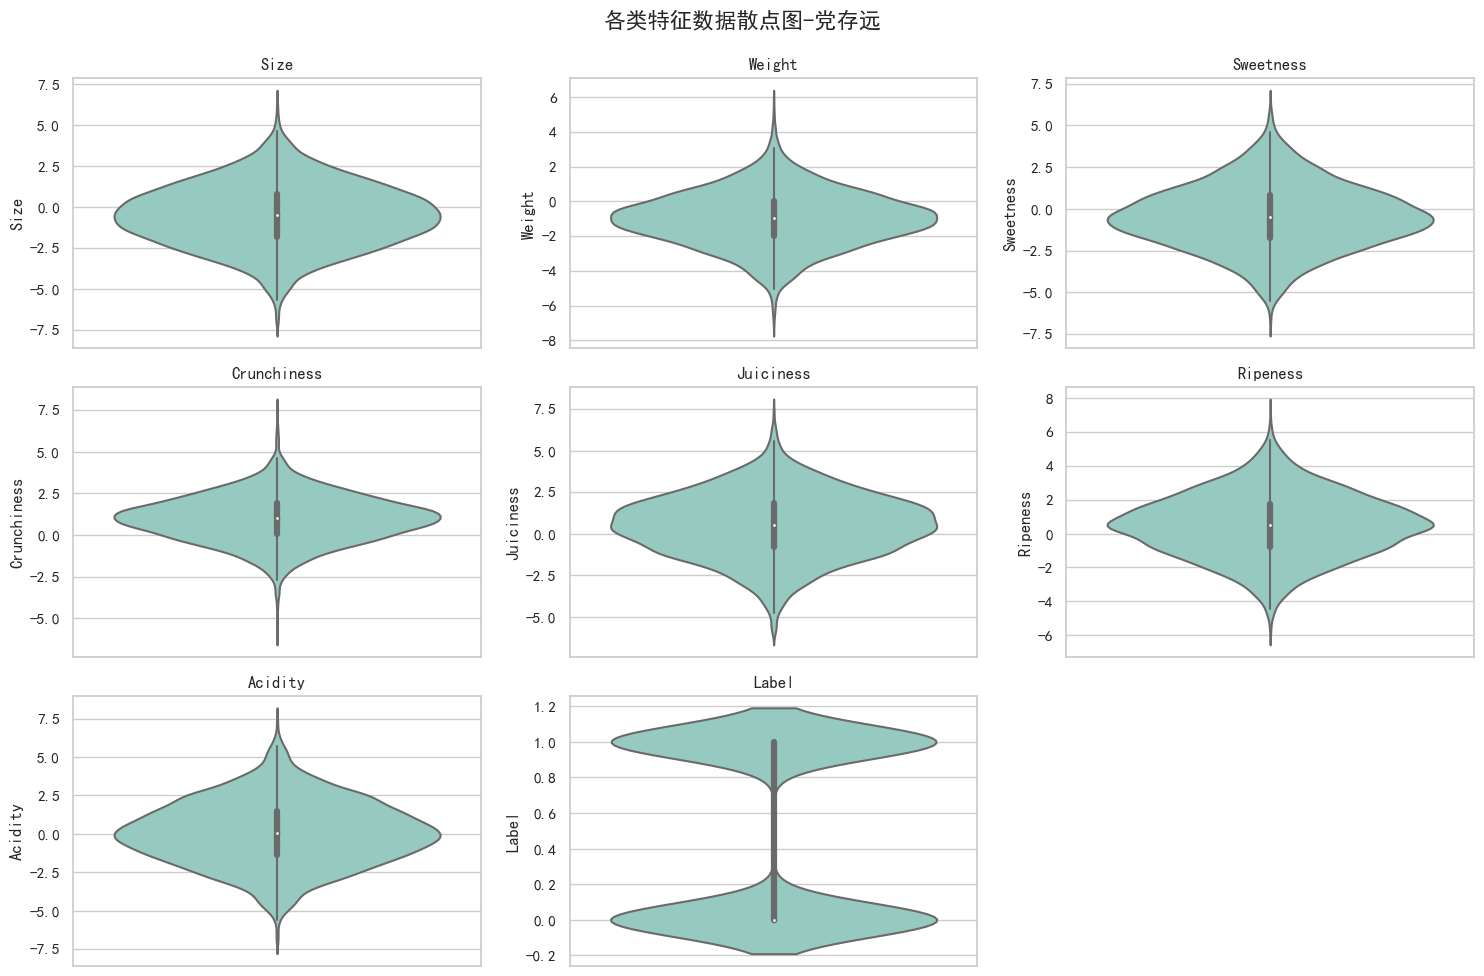

In [116]:
plt.figure(figsize=(15, 10))
sns.set_palette("Set3")
for i, column in enumerate(numerical_cols, 1):
    plt.subplot(3, 3, i)
    sns.violinplot(y=df_clean[column])
    plt.title(column)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.suptitle('各类特征数据散点图-党存远', fontsize=16)  
plt.show()

In [117]:
# 数据热力图

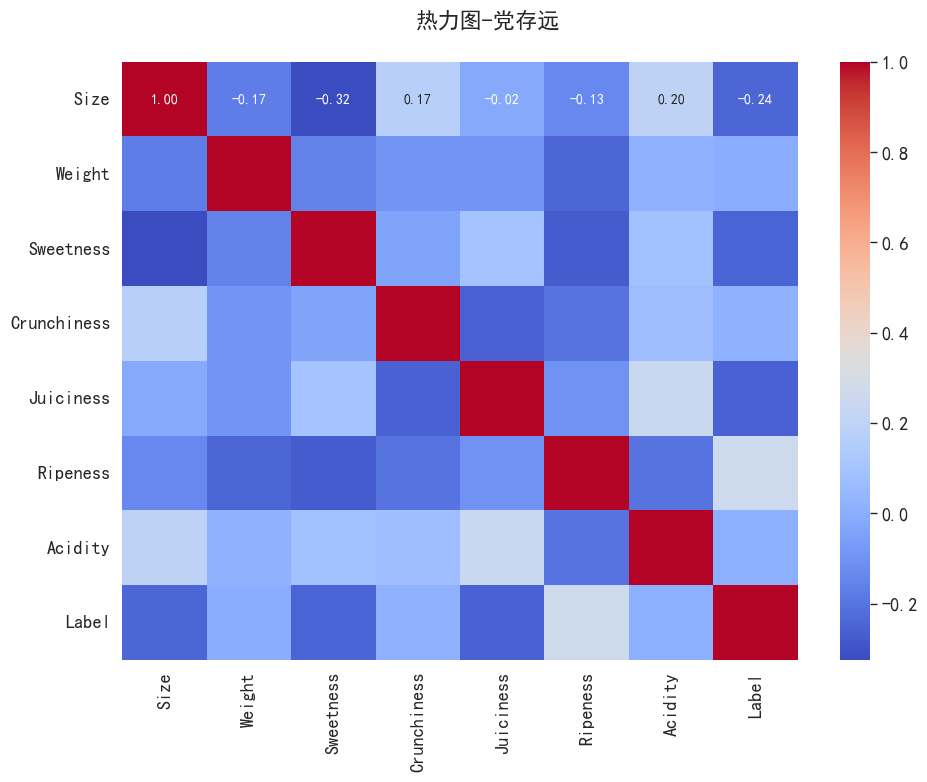

In [118]:
plt.figure(figsize=(10, 8))  
corr = df_clean[numerical_cols].corr()  
sns.set_context('paper', font_scale=1.5)
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 10})  # 调整注释字体大小
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.suptitle('热力图-党存远', fontsize=16)  
plt.show()

#### 3.2.2 双列对比图

In [119]:
# 双列箱式图

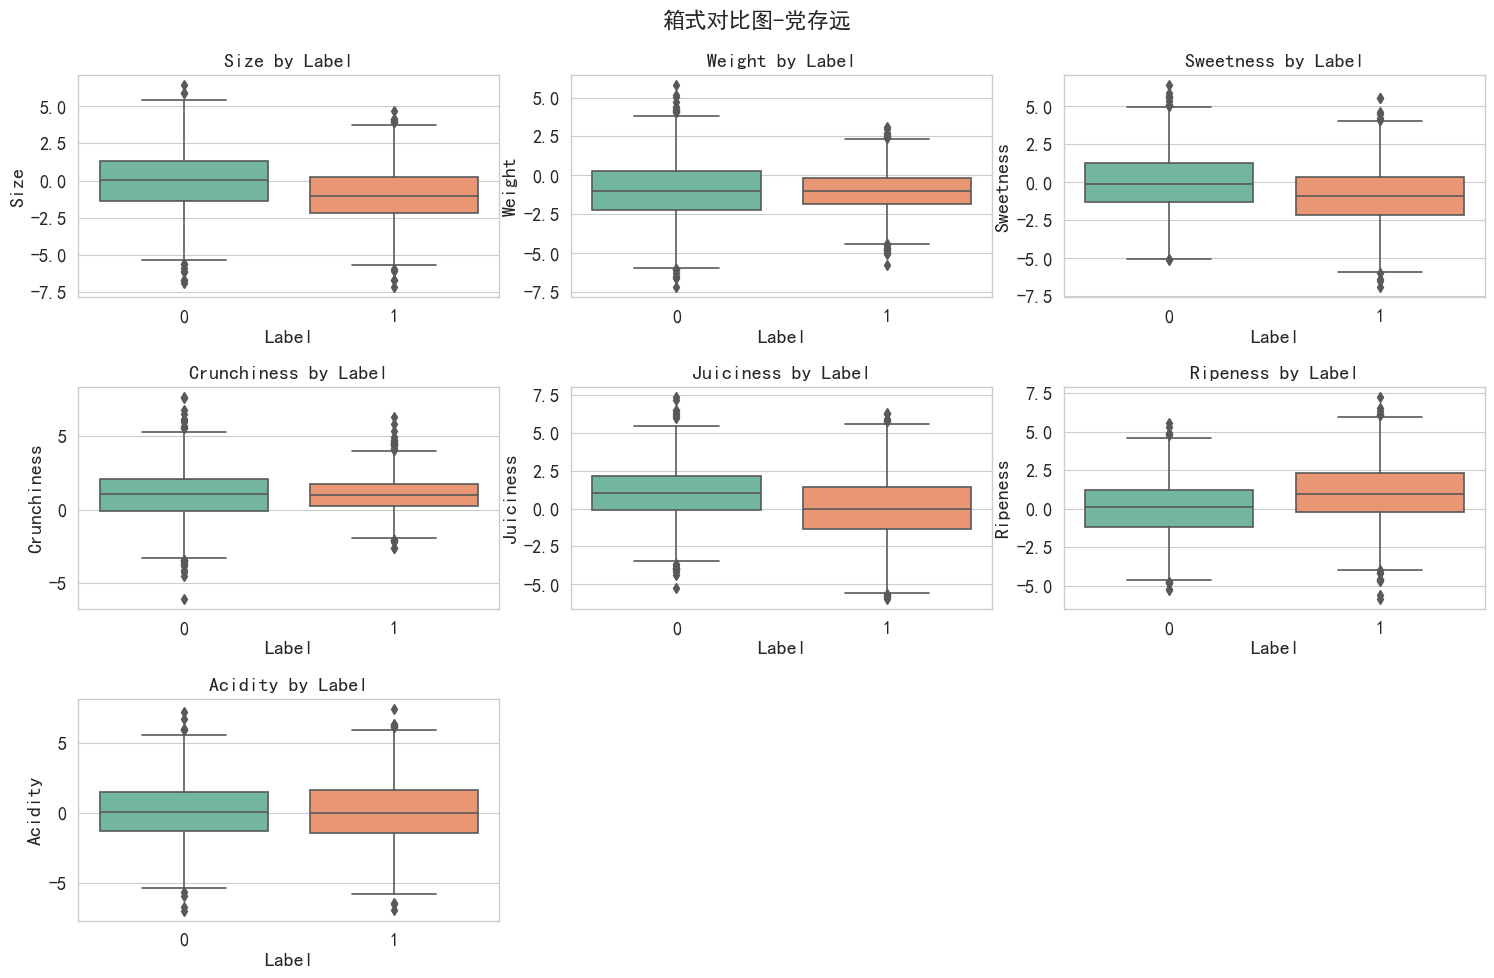

In [120]:
plt.figure(figsize=(15, 10))
sns.set_palette("Set2")

for i, column in enumerate(df_clean.columns[:-1]):  
    plt.subplot(3, 3, i + 1)
    sns.boxplot(x='Label', y=column, data=df_clean)
    plt.title(f'{column} by Label')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.suptitle('箱式对比图-党存远', fontsize=16)  
plt.tight_layout()
plt.show()

In [121]:
# 双列散点图

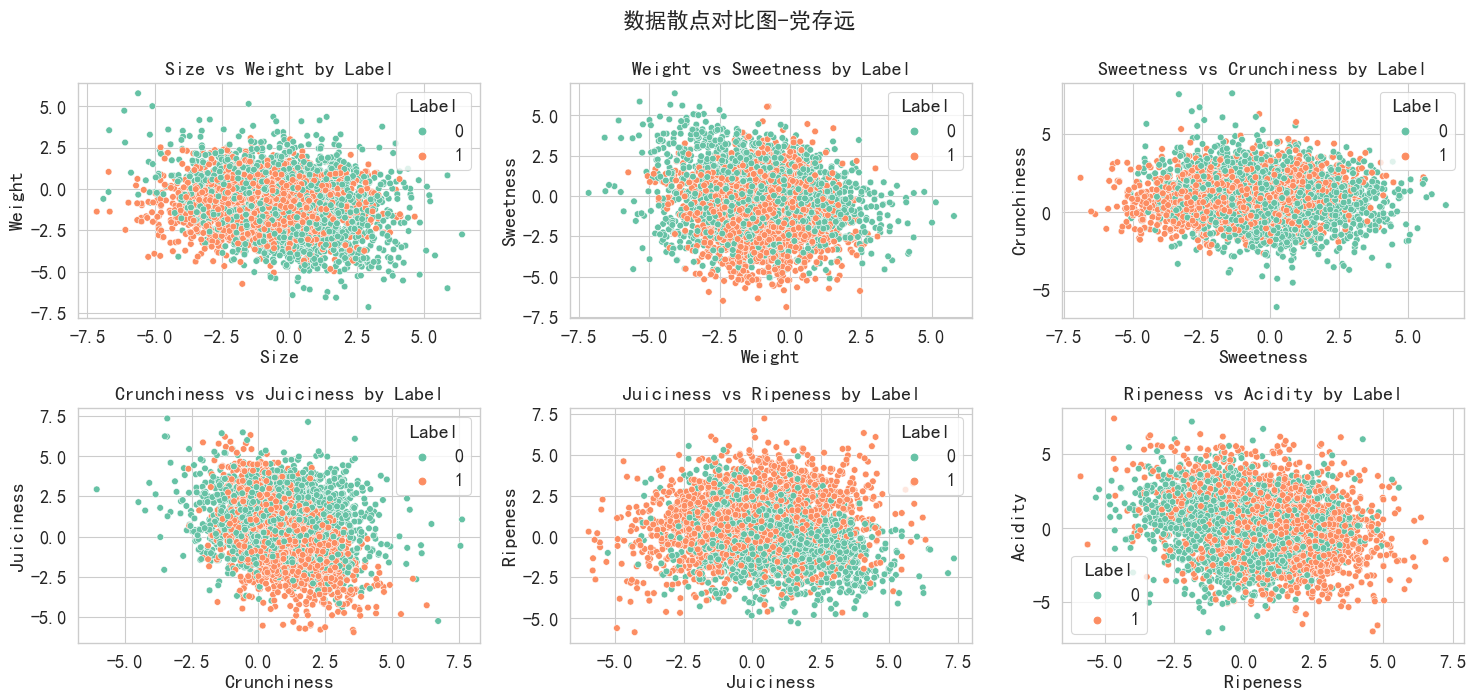

In [122]:
plt.figure(figsize=(15, 10))
sns.set_palette("Set2")

for i in range(1, len(df_clean.columns[:-1])):
    plt.subplot(3, 3, i)
    sns.scatterplot(x=df_clean.columns[i-1], y=df_clean.columns[i], hue=df_clean['Label'], data=df_clean)
    plt.title(f'{df_clean.columns[i-1]} vs {df_clean.columns[i]} by Label')
plt.tight_layout()
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.suptitle('数据散点对比图-党存远', fontsize=16)  

plt.show()

#### 3.2.3  多列

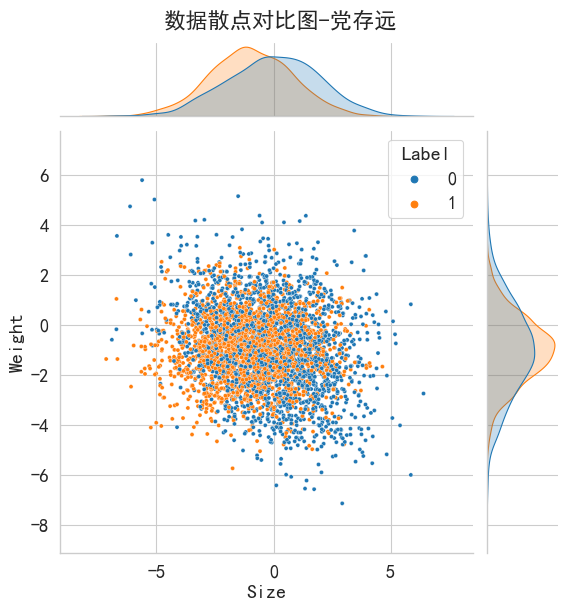

In [123]:


matplotlib.rcParams['font.sans-serif'] = ['SimHei']  
matplotlib.rcParams['axes.unicode_minus'] = False  

joint_plot = sns.jointplot(x='Size', y='Weight', hue='Label', data=df_clean, palette='tab10', s=9)

joint_plot.fig.suptitle('数据散点对比图-党存远', fontsize=16, y=1.02) 

plt.show()

In [124]:
# Sweetness与Crunchiness对比散点图

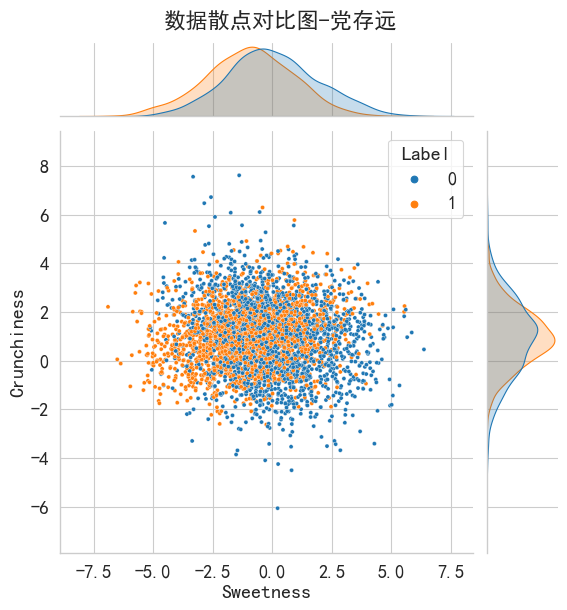

In [125]:
matplotlib.rcParams['font.sans-serif'] = ['SimHei'] 
matplotlib.rcParams['axes.unicode_minus'] = False  
joint_plot = sns.jointplot(x='Sweetness', y='Crunchiness', hue='Label', data=df_clean, palette='tab10', s=9)

joint_plot.fig.suptitle('数据散点对比图-党存远', fontsize=16, y=1.02)
plt.show()

In [126]:
# Ripeness 与 Juiciness对比散点图

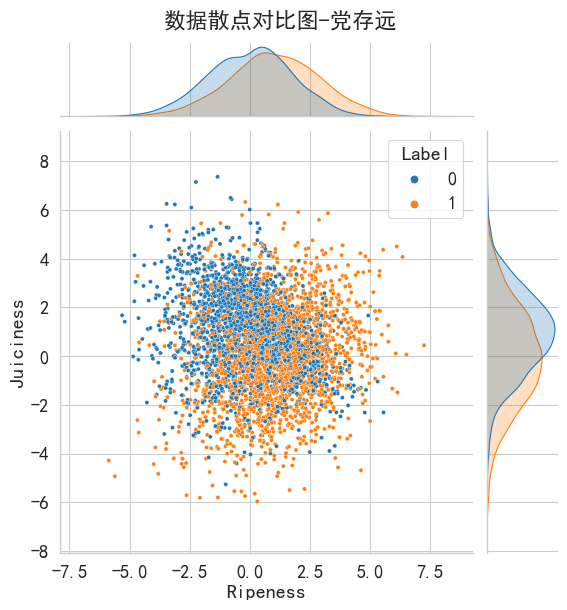

In [127]:

matplotlib.rcParams['font.sans-serif'] = ['SimHei'] 
matplotlib.rcParams['axes.unicode_minus'] = False   
joint_plot = sns.jointplot(x='Ripeness', y='Juiciness', hue='Label', data=df_clean, palette='tab10', s=9)
joint_plot.fig.suptitle('数据散点对比图-党存远', fontsize=16, y=1.02)
plt.show()

#### 3.3  相关热图

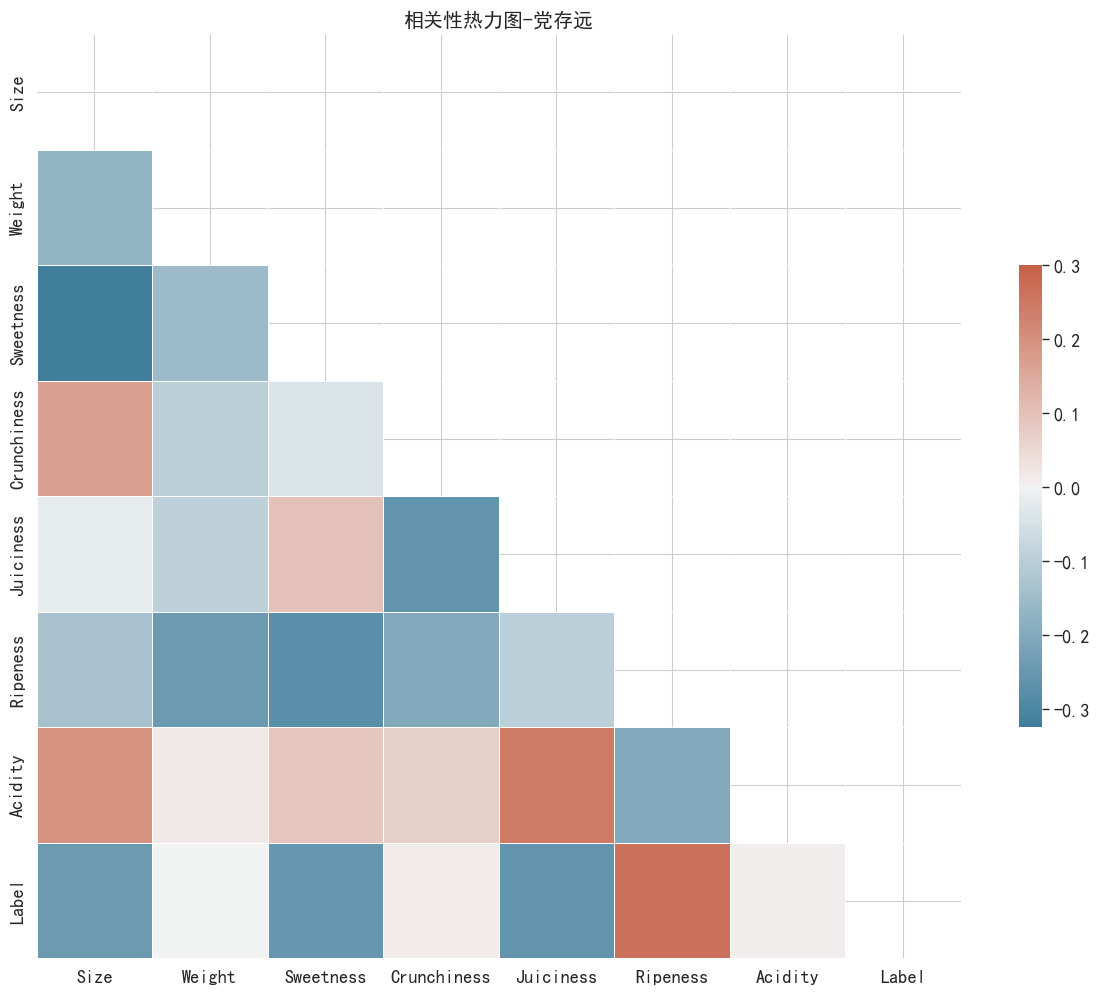

In [128]:
matplotlib.rcParams['font.sans-serif'] = ['SimHei']  
matplotlib.rcParams['axes.unicode_minus'] = False  

corr = df_clean.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(15, 12))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.title('相关性热力图-党存远')

plt.show()

## 4. 预处理

### 4.1  异常处理

In [129]:
# 对7种特征进行标准化后筛选出异常数据

In [130]:
numerical_features = ['Size', 'Weight', 'Sweetness', 'Crunchiness', 'Juiciness', 'Ripeness',
       'Acidity']

robust_scaler = RobustScaler()

df_clean[numerical_features] = robust_scaler.fit_transform(df_clean[numerical_features])

def count_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return ((series < lower_bound) | (series > upper_bound)).sum()

for feature in numerical_features :
    num_outliers = count_outliers(df_clean[feature])
    print(f'Number of outliers in {feature}: {num_outliers}')

Number of outliers in Size: 22
Number of outliers in Weight: 54
Number of outliers in Sweetness: 32
Number of outliers in Crunchiness: 47
Number of outliers in Juiciness: 32
Number of outliers in Ripeness: 24
Number of outliers in Acidity: 20


In [131]:
scaler = StandardScaler()
df_clean[numerical_features] = scaler.fit_transform(df_clean[numerical_features])

### 4.2  假设检验

In [132]:
# 假设检验是一种统计方法，用于根据有关总体的拟议声明或假设的样本数据做出决策。在这个过程中，检查从样本中发现的证据是否足够强大，以支持或反驳关于总体参数的陈述。

T统计量: 6.950226687826504e-16
P值: 0.9999999999999994


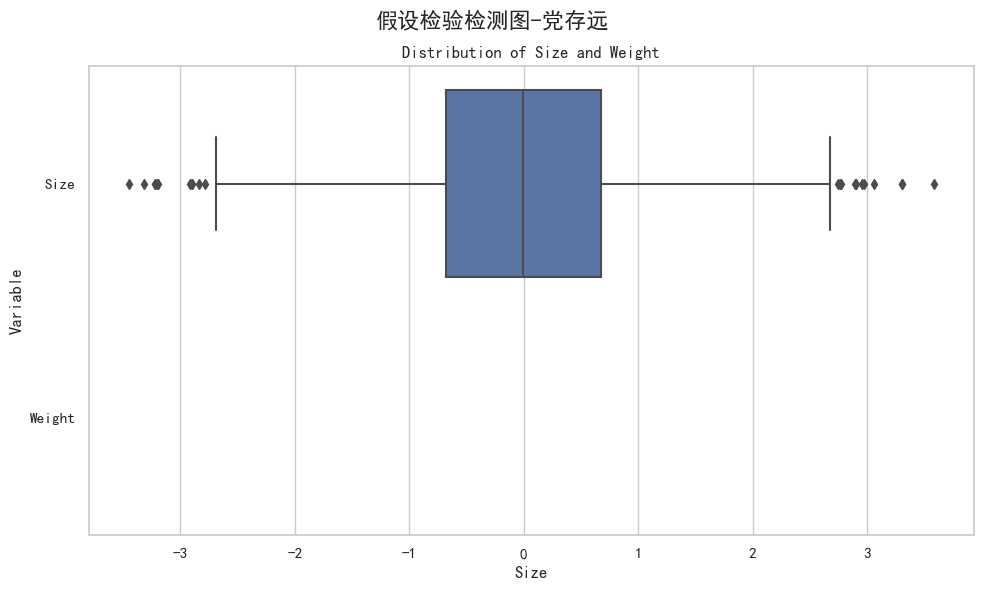

T统计量: -3.971558107329431e-16
P值: 0.9999999999999997


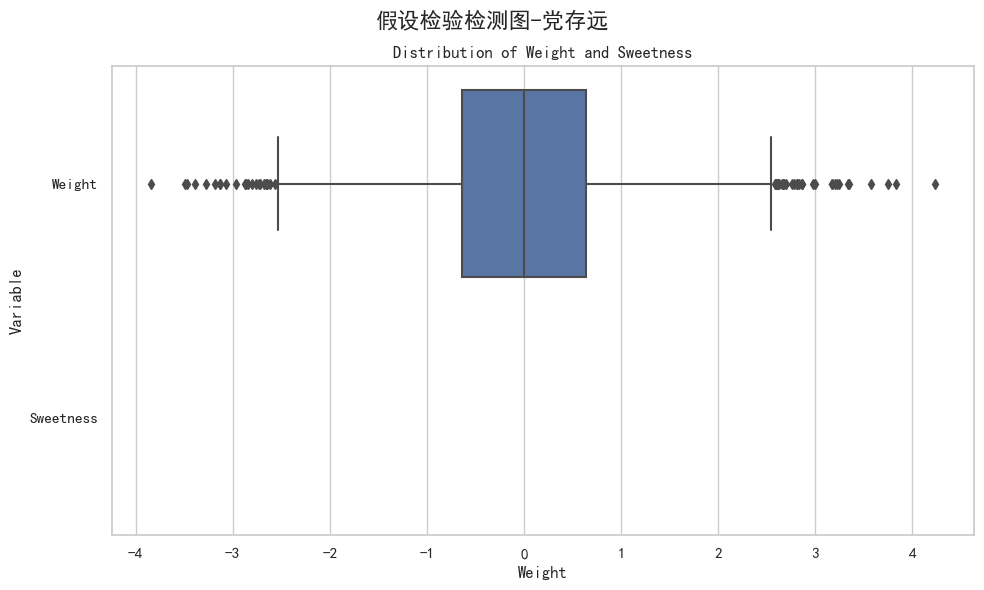

T统计量: 9.730317362957104e-16
P值: 0.9999999999999992


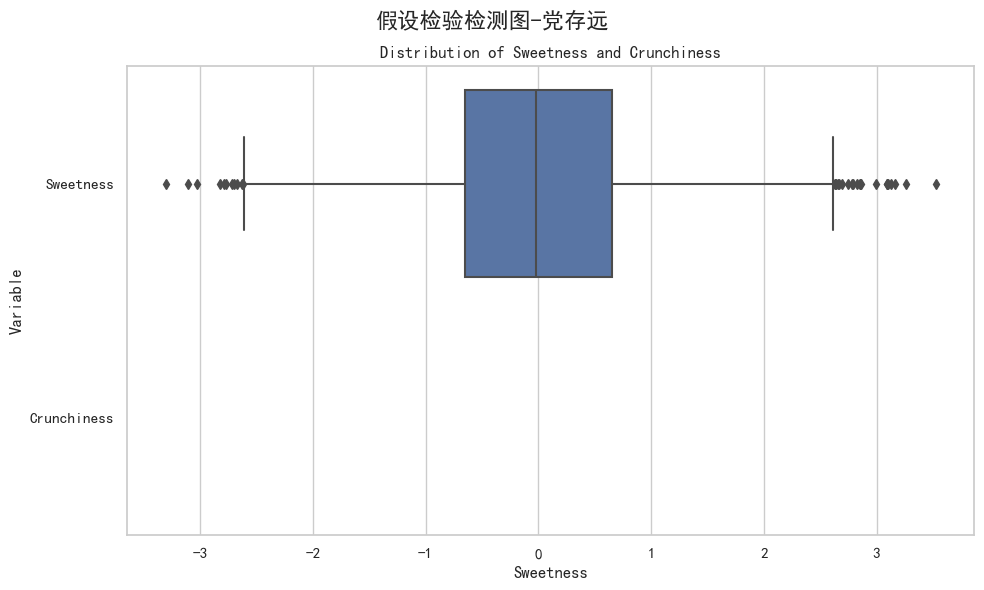

T统计量: -1.707769986151655e-15
P值: 0.9999999999999987


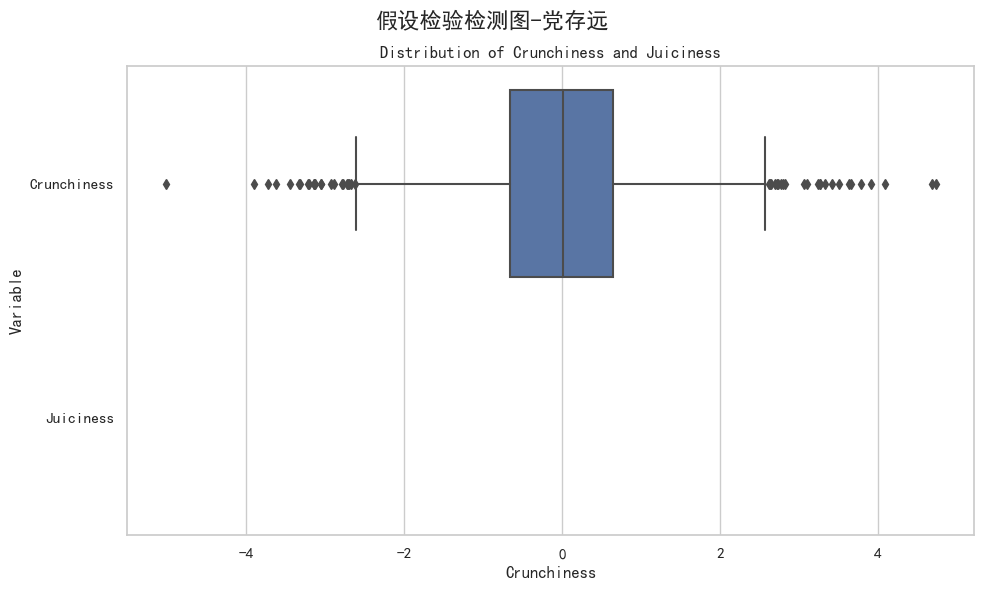

T统计量: 1.707769986151655e-15
P值: 0.9999999999999987


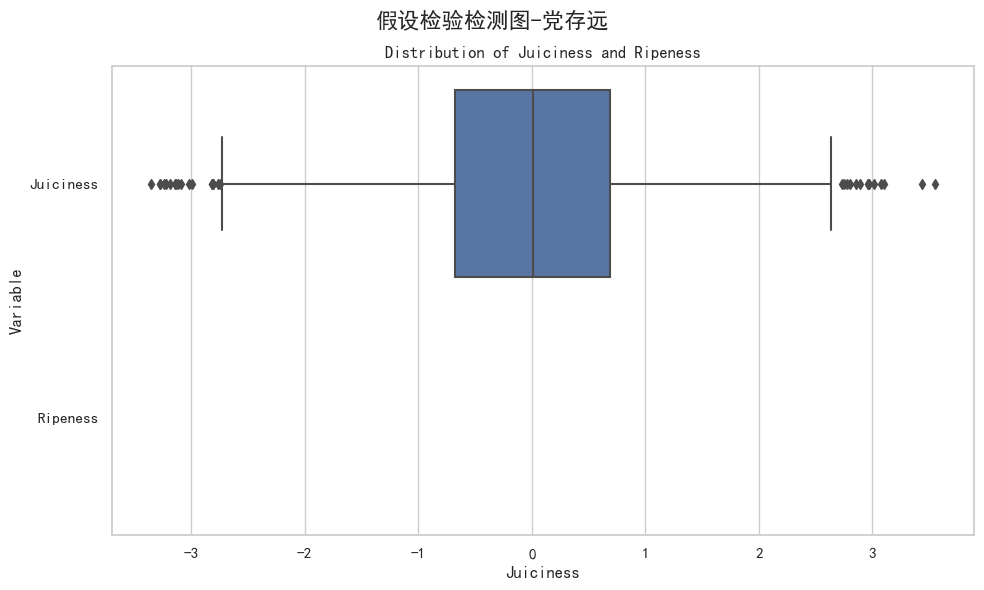

T统计量: -1.5886232429317723e-16
P值: 0.9999999999999999


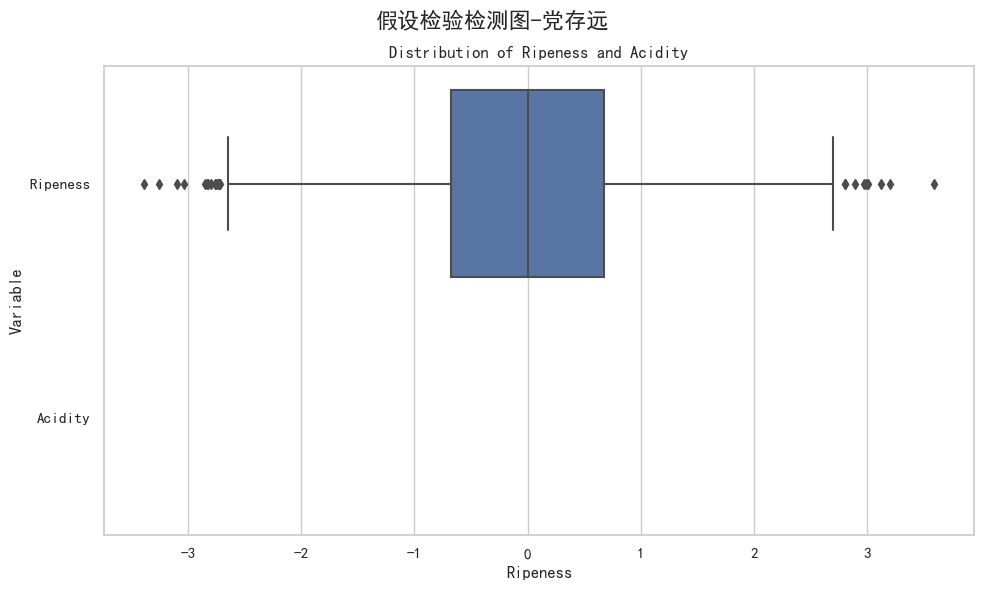

In [133]:
sns.set(style="whitegrid")
def hypothesis_testing(df, column1, column2):
    matplotlib.rcParams['font.sans-serif'] = ['SimHei']  
    matplotlib.rcParams['axes.unicode_minus'] = False  
    t_stat, p_val = stats.ttest_ind(df[column1], df[column2])
    
    print("T统计量:", t_stat)
    print("P值:", p_val)
    
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=df[column1], y="Variable", data=pd.melt(df[[column1, column2]], var_name="Variable"))
    plt.title(f'Distribution of {column1} and {column2}')
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.suptitle('假设检验检测图-党存远', fontsize=16)  
    plt.show()

columns_for_testing = ['Size', 'Weight', 'Sweetness', 'Crunchiness', 'Juiciness', 'Ripeness', 'Acidity']
for i in range(len(columns_for_testing) - 1):
    hypothesis_testing(df_clean, columns_for_testing[i], columns_for_testing[i + 1])

In [134]:
# 上图显示出了7种不同的特征的分布情况

### 4.3 不平衡数据

In [135]:
# 数据分类

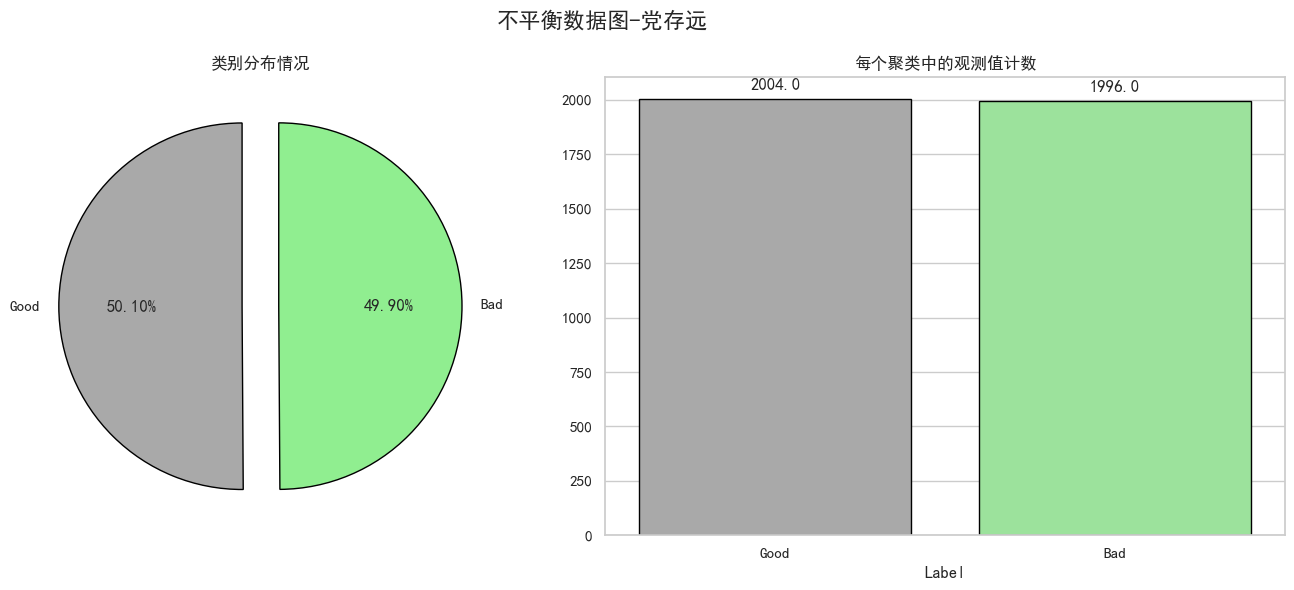

In [136]:
good_count = df_clean['Label'].eq(0).sum()
bad_count = df_clean['Label'].eq(1).sum()
total_count = len(df_clean)

good_percentage = (good_count / total_count) * 100
bad_percentage = (bad_count / total_count) * 100

label_counts = df_clean['Label'].value_counts()

plt.figure(figsize=(14, 6))

plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签

# Subplot 1 - Pie Chart
plt.subplot(1, 2, 1)
pie_values = [good_percentage, bad_percentage]
colors = ['darkgrey', 'lightgreen']
plt.pie(pie_values, labels=['Good', 'Bad'],
        autopct='%1.2f%%',
        startangle=90,
        explode=(0.1, 0.1),
        colors=colors,
        wedgeprops={'edgecolor': 'black', 'linewidth': 1, 'antialiased': True})
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.suptitle('不平衡数据图-党存远', fontsize=16)  
plt.title('类别分布情况')

# Subplot 2 - Bar Chart
plt.subplot(1, 2, 2)
colors = ['darkgrey', 'lightgreen']
ax = sns.barplot(x=label_counts.index, y=label_counts.values, palette=colors, edgecolor='black')
for i in ax.patches:
    ax.annotate(f'{i.get_height()}', (i.get_x() + i.get_width() / 2., i.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')
ax.set_xticks([0, 1])  
ax.set_xticklabels(['Good', 'Bad'])

plt.title('每个聚类中的观测值计数')

plt.tight_layout()
plt.show()


### 4.4  标准化 

In [137]:
df1 = df_clean.copy()

In [138]:
X = df1.drop(['Label'], axis=1)
y = df1['Label']


In [139]:
scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

In [140]:
X_resampled.describe().T.style.background_gradient(axis=0, cmap='viridis')

In [141]:
# 上图显示出了数据进行标准化后的结果

### 4.5 划分数据集

In [142]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

### 4.6 PCA 降维处理 

In [143]:
# 将训练集和测试集组合后进行pca降维操作

In [144]:
X_combined = np.vstack([X_train, X_test])
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_combined)

In [145]:
X_train_pca = principal_components[:len(X_train)]
X_test_pca = principal_components[len(X_train):]

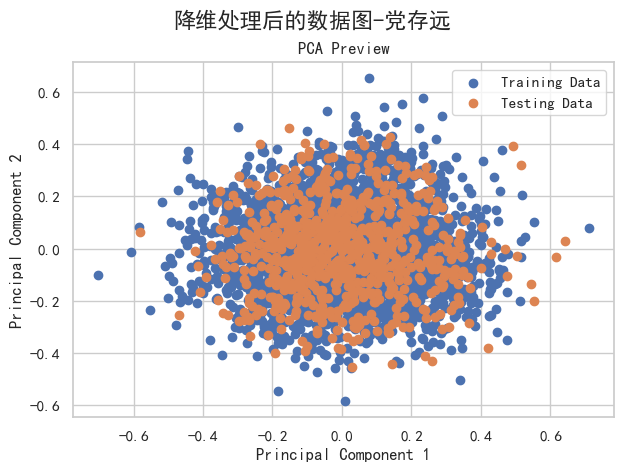

In [147]:
plt.rcParams['axes.unicode_minus'] = False 
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], label='Training Data')
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], label='Testing Data')
plt.title('PCA Preview')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.suptitle('降维处理后的数据图-党存远', fontsize=16)  
plt.show()

## 5. 模型搭建

In [148]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc

 ### 5.1 SVC 

In [149]:
# 未使用PCA降维的SVC

In [150]:
param_dist = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto', 0.1, 1],
}

svc = SVC()

randomized_search = RandomizedSearchCV(svc, param_distributions=param_dist, n_iter=10, cv=5, scoring='accuracy', random_state=42, n_jobs=-1)

randomized_search.fit(X_train, y_train)

best_params = randomized_search.best_params_
print(f"Best Hyperparameters: {best_params}")

best_svc_model = randomized_search.best_estimator_
svc_predicted = best_svc_model.predict(X_test)

svc_acc_score = accuracy_score(y_test, svc_predicted)
svc_conf_matrix = confusion_matrix(y_test, svc_predicted)

print("\n混淆矩阵 :")
print(svc_conf_matrix)
print("\n支持向量分类器测试集得分:", svc_acc_score * 100, '\n')
print("分类报告:")
print(classification_report(y_test, svc_predicted))


Best Hyperparameters: {'kernel': 'rbf', 'gamma': 'scale', 'C': 10}

混淆矩阵 :
[[373  39]
 [ 29 361]]

支持向量分类器测试集得分: 91.52119700748129 

分类报告:
              precision    recall  f1-score   support

           0       0.93      0.91      0.92       412
           1       0.90      0.93      0.91       390

    accuracy                           0.92       802
   macro avg       0.92      0.92      0.92       802
weighted avg       0.92      0.92      0.92       802



In [151]:
# 使用PCA降维处理后的SVC

In [152]:
# 使用降维后的数据训练 
svc = SVC(C=best_params['C'], kernel=best_params['kernel'], gamma=best_params['gamma'])
svc.fit(X_train_pca, y_train)

svc_predicted_pca_test = svc.predict(X_test_pca)
# 计算并显示准确率
svc_acc_score_pca_test = accuracy_score(y_test, svc_predicted_pca_test)
print("支持向量分类器在降维后的测试集上的准确率为:", svc_acc_score_pca_test * 100, "%")

支持向量分类器在降维后的测试集上的准确率为: 65.46134663341647 %


In [153]:
# 可视化决策边界与数据点

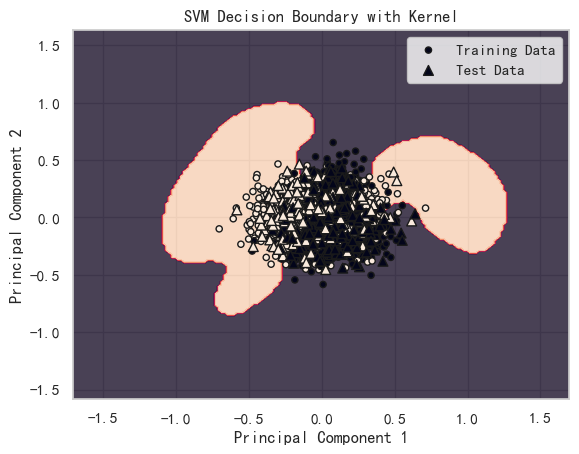

In [154]:
# 创建网格以绘制决策边界
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))

Z = svc.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.8)
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, edgecolors='k', s=20, marker='o', label='Training Data')
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test, edgecolors='k', s=50, marker='^', label='Test Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('SVM Decision Boundary with Kernel')
plt.legend()
plt.show()

In [155]:
# 如上图以及数据准确率所示降维后结果较差

### 5.2 决策树

In [156]:
from sklearn.tree import DecisionTreeClassifier  
from sklearn.model_selection import RandomizedSearchCV  
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report  
  
param_dist_dt = {  
    'max_depth': [3, 5, 7, None],  
    'min_samples_split': [2, 5, 10],  
}  
  
dt = DecisionTreeClassifier()  
  
randomized_search_dt = RandomizedSearchCV(dt, param_distributions=param_dist_dt, n_iter=10, cv=5, scoring='accuracy', random_state=42, n_jobs=-1)  
  
randomized_search_dt.fit(X_train, y_train)  

best_params_dt = randomized_search_dt.best_params_  
print(f"Best Hyperparameters for Decision Tree: {best_params_dt}")  
  
best_dt_model = randomized_search_dt.best_estimator_  
dt_predicted = best_dt_model.predict(X_test)  
  
dt_acc_score = accuracy_score(y_test, dt_predicted)  
dt_conf_matrix = confusion_matrix(y_test, dt_predicted)  
  
print("\n混淆矩阵 for Decision Tree:")  
print(dt_conf_matrix)  
print("\n决策树得分:", dt_acc_score * 100, '\n')  
print("对于决策树的分类报告")  
print(classification_report(y_test, dt_predicted))

Best Hyperparameters for Decision Tree: {'min_samples_split': 10, 'max_depth': 7}

混淆矩阵 for Decision Tree:
[[282 130]
 [ 48 342]]

决策树得分: 77.80548628428927 

对于决策树的分类报告
              precision    recall  f1-score   support

           0       0.85      0.68      0.76       412
           1       0.72      0.88      0.79       390

    accuracy                           0.78       802
   macro avg       0.79      0.78      0.78       802
weighted avg       0.79      0.78      0.78       802



In [157]:
#文本形式绘制决策规则
from sklearn import tree
text_representation = tree.export_text(best_dt_model)
print(text_representation)

|--- feature_4 <= 0.42
|   |--- feature_1 <= 0.67
|   |   |--- feature_0 <= 0.50
|   |   |   |--- feature_5 <= 0.39
|   |   |   |   |--- feature_2 <= 0.53
|   |   |   |   |   |--- feature_4 <= 0.33
|   |   |   |   |   |   |--- feature_0 <= 0.43
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- feature_0 >  0.43
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- feature_4 >  0.33
|   |   |   |   |   |   |--- feature_4 <= 0.41
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- feature_4 >  0.41
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |--- feature_2 >  0.53
|   |   |   |   |   |--- feature_3 <= 0.45
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- feature_3 >  0.45
|   |   |   |   |   |   |--- feature_5 <= 0.26
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- feature_5 >  0.26
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |--- feature_5 >  0.39
|   |   |   |   |--- featur

### 5.3 逻辑回归

In [158]:
from sklearn.linear_model import LogisticRegression  
  
# 定义逻辑回归的参数网格  
param_dist_lr = {  
    'C': [0.1, 1, 10],  
    'penalty': ['l1', 'l2'],  
    'solver': ['liblinear', 'saga'],  
    # 可以添加更多参数，但以上通常足以开始  
}  
  
lr = LogisticRegression(max_iter=1000) 

randomized_search_lr = RandomizedSearchCV(lr, param_distributions=param_dist_lr, n_iter=10, cv=5, scoring='accuracy', random_state=42, n_jobs=-1)  
  

randomized_search_lr.fit(X_train, y_train)  
  
best_params_lr = randomized_search_lr.best_params_  
print(f"Best Hyperparameters for Logistic Regression: {best_params_lr}")  
  
best_lr_model = randomized_search_lr.best_estimator_  
lr_predicted = best_lr_model.predict(X_test)  
  
lr_acc_score = accuracy_score(y_test, lr_predicted)  
lr_conf_matrix = confusion_matrix(y_test, lr_predicted)  
  
print("\n混淆矩阵 for Logistic Regression:")  
print(lr_conf_matrix)  
print("\n逻辑回归准确率:", lr_acc_score * 100, '\n')  
print("分类报告 for Logistic Regression:")  
print(classification_report(y_test, lr_predicted))

Best Hyperparameters for Logistic Regression: {'solver': 'liblinear', 'penalty': 'l1', 'C': 1}

混淆矩阵 for Logistic Regression:
[[301 111]
 [ 97 293]]

逻辑回归准确率: 74.06483790523691 

分类报告 for Logistic Regression:
              precision    recall  f1-score   support

           0       0.76      0.73      0.74       412
           1       0.73      0.75      0.74       390

    accuracy                           0.74       802
   macro avg       0.74      0.74      0.74       802
weighted avg       0.74      0.74      0.74       802



### 5.4 随机森林

In [159]:
param_dist_rf = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy'],
}

rf = RandomForestClassifier()

randomized_search_rf = RandomizedSearchCV(
    rf,
    param_distributions=param_dist_rf,
    n_iter=10,
    cv=5,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1
)

randomized_search_rf.fit(X_train, y_train)

best_params_rf = randomized_search_rf.best_params_
print(f"Best Hyperparameters for Random Forest: {best_params_rf}")

best_rf_model = randomized_search_rf.best_estimator_

rf_predicted = best_rf_model.predict(X_test)

rf_acc_score = accuracy_score(y_test, rf_predicted)
rf_conf_matrix = confusion_matrix(y_test, rf_predicted)


import os  
from sklearn.tree import export_graphviz    
for i, tree in enumerate(best_rf_model.estimators_):  
    if i >= 3:  
        break  # 只导出前三棵树  
      
    # 创建文件名  
    dot_data = export_graphviz(tree, out_file=None,   
                               feature_names=X_train.columns.values,  
                               class_names=best_rf_model.classes_.astype(str),    
                               filled=True, rounded=True,    
                               special_characters=True)  
      
    # 将 dot_data 写入文件  
    file_name = f'tree_{i}.dot'  
    with open(file_name, 'w') as f:  
        f.write(dot_data)  
      
    print(f"Tree {i} has been saved to {file_name}")
    
print("\n混淆矩阵:")
print(rf_conf_matrix)
print("\n随机森林得分:", rf_acc_score * 100, '\n')
print("分类报告:")
print(classification_report(y_test, rf_predicted))


Best Hyperparameters for Random Forest: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 30, 'criterion': 'entropy', 'bootstrap': True}
Tree 0 has been saved to tree_0.dot
Tree 1 has been saved to tree_1.dot
Tree 2 has been saved to tree_2.dot

混淆矩阵:
[[367  45]
 [ 45 345]]

随机森林得分: 88.7780548628429 

分类报告:
              precision    recall  f1-score   support

           0       0.89      0.89      0.89       412
           1       0.88      0.88      0.88       390

    accuracy                           0.89       802
   macro avg       0.89      0.89      0.89       802
weighted avg       0.89      0.89      0.89       802



#### 5.4.1  前三棵树

![jupyter](./1.svg)

![jupyter](./2.svg)

![jupyter](./3.svg)

### 5.5  K近邻

In [160]:
param_dist_knn = {
    'n_neighbors': [3, 5, 7, 10],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [10, 20, 30, 40],
    'p': [1, 2],
}

knn = KNeighborsClassifier()

randomized_search_knn = RandomizedSearchCV(
    knn,
    param_distributions=param_dist_knn,
    n_iter=10,
    cv=5,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1
)

randomized_search_knn.fit(X_train, y_train)

best_params_knn = randomized_search_knn.best_params_
print(f"Best Hyperparameters for KNeighborsClassifier: {best_params_knn}")

best_knn_model = randomized_search_knn.best_estimator_

knn_predicted = best_knn_model.predict(X_test)

knn_acc_score = accuracy_score(y_test, knn_predicted)
knn_conf_matrix = confusion_matrix(y_test, knn_predicted)

print("\n混淆矩阵:")
print(knn_conf_matrix)
print("\nK近邻得分:", knn_acc_score * 100, '\n')
print("分类报告:")
print(classification_report(y_test, knn_predicted))


Best Hyperparameters for KNeighborsClassifier: {'weights': 'distance', 'p': 2, 'n_neighbors': 5, 'leaf_size': 30, 'algorithm': 'kd_tree'}

混淆矩阵:
[[365  47]
 [ 42 348]]

K近邻得分: 88.90274314214463 

分类报告:
              precision    recall  f1-score   support

           0       0.90      0.89      0.89       412
           1       0.88      0.89      0.89       390

    accuracy                           0.89       802
   macro avg       0.89      0.89      0.89       802
weighted avg       0.89      0.89      0.89       802



### 5.6 神经网络

In [96]:
print(X_train.shape)

(3206, 7)


In [97]:
print(y_train)

2473    0
1338    1
1613    1
1610    1
2600    1
       ..
1130    0
1294    1
860     0
3507    0
3174    0
Name: Label, Length: 3206, dtype: int64


In [98]:
# 首先尝试简单的神经网络模型

In [110]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [111]:
model = Sequential([
    Dense(100, activation='relu', input_shape=(7,)), 
    Dense(75, activation='relu'),
    Dropout(0.2),  # Dropout减轻过拟合
    Dense(50, activation='relu'),  
    Dense(25, activation='relu'),
    Dense(12, activation='relu'),
    Dense(2, activation='softmax')  
])
# 查看模型结构
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_22 (Dense)            (None, 100)               800       
                                                                 
 dense_23 (Dense)            (None, 75)                7575      
                                                                 
 dropout_2 (Dropout)         (None, 75)                0         
                                                                 
 dense_24 (Dense)            (None, 50)                3800      
                                                                 
 dense_25 (Dense)            (None, 25)                1275      
                                                                 
 dense_26 (Dense)            (None, 12)                312       
                                                                 
 dense_27 (Dense)            (None, 2)                

In [112]:
model.compile(
    optimizer='adam',  
    loss='sparse_categorical_crossentropy',  
    metrics=['accuracy']  
)

In [116]:
history = model.fit(X_train, y_train, epochs=40, validation_split=0.2)  

Epoch 1/40
81/81 [==============================] - 0s 5ms/step - loss: 0.2187 - accuracy: 0.9130 - val_loss: 0.2410 - val_accuracy: 0.8972
Epoch 2/40
81/81 [==============================] - 0s 3ms/step - loss: 0.1608 - accuracy: 0.9341 - val_loss: 0.2394 - val_accuracy: 0.9143
Epoch 3/40
81/81 [==============================] - 0s 4ms/step - loss: 0.1669 - accuracy: 0.9329 - val_loss: 0.2298 - val_accuracy: 0.9128
Epoch 4/40
81/81 [==============================] - 0s 5ms/step - loss: 0.1688 - accuracy: 0.9275 - val_loss: 0.2485 - val_accuracy: 0.9034
Epoch 5/40
81/81 [==============================] - 0s 3ms/step - loss: 0.1611 - accuracy: 0.9310 - val_loss: 0.2406 - val_accuracy: 0.9034
Epoch 6/40
81/81 [==============================] - 0s 4ms/step - loss: 0.1655 - accuracy: 0.9345 - val_loss: 0.2228 - val_accuracy: 0.9206
Epoch 7/40
81/81 [==============================] - 0s 3ms/step - loss: 0.1690 - accuracy: 0.9286 - val_loss: 0.2246 - val_accuracy: 0.9206
Epoch 8/40
81/81 [==

In [117]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print("\n测试集上的准确率:", test_acc)

26/26 [==============================] - 0s 3ms/step - loss: 0.2183 - accuracy: 0.9227

测试集上的准确率: 0.9226932525634766


In [121]:
# 采用MLP多层感知机

In [122]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

param_dist_nn = {
    'hidden_layer_sizes': [(50,), (100,), (50,50), (100,50)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

nn = MLPClassifier(max_iter=1000, random_state=42)

randomized_search_nn = RandomizedSearchCV(
    nn,
    param_distributions=param_dist_nn,
    n_iter=10,
    cv=5,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1
)

In [123]:
randomized_search_nn.fit(X_train, y_train)

best_params_nn = randomized_search_nn.best_params_
print(f"最好的超参数: {best_params_nn}")

最好的超参数: {'solver': 'adam', 'learning_rate': 'constant', 'hidden_layer_sizes': (100, 50), 'alpha': 0.05, 'activation': 'relu'}


In [124]:
best_nn_model = randomized_search_nn.best_estimator_

nn_predicted = best_nn_model.predict(X_test)
nn_acc_score = accuracy_score(y_test, nn_predicted)
nn_conf_matrix = confusion_matrix(y_test, nn_predicted)

print("\n混淆矩阵:")
print(nn_conf_matrix)
print("\n神经网络准确率:", nn_acc_score * 100, '\n')
print("分类报告:")
print(classification_report(y_test, nn_predicted))


混淆矩阵:
[[373  39]
 [ 64 326]]

神经网络准确率: 87.1571072319202 

分类报告:
              precision    recall  f1-score   support

           0       0.85      0.91      0.88       412
           1       0.89      0.84      0.86       390

    accuracy                           0.87       802
   macro avg       0.87      0.87      0.87       802
weighted avg       0.87      0.87      0.87       802



In [125]:
# 查看结果发现数据神经网络的准确率有所下降 继续更改模型

In [ ]:
# CNN

In [126]:
from keras.layers import Conv1D, Flatten

model_cnn = Sequential([
    Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(7,1)),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])
model_cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [130]:
model_cnn.fit(X_train, y_train, epochs=40, batch_size=32)

Epoch 1/40
101/101 [==============================] - 0s 2ms/step - loss: 0.3472 - accuracy: 0.8437
Epoch 2/40
101/101 [==============================] - 0s 1ms/step - loss: 0.3499 - accuracy: 0.8400
Epoch 3/40
101/101 [==============================] - 0s 2ms/step - loss: 0.3451 - accuracy: 0.8453
Epoch 4/40
101/101 [==============================] - 0s 2ms/step - loss: 0.3442 - accuracy: 0.8493
Epoch 5/40
101/101 [==============================] - 0s 2ms/step - loss: 0.3409 - accuracy: 0.8437
Epoch 6/40
101/101 [==============================] - 0s 2ms/step - loss: 0.3394 - accuracy: 0.8472
Epoch 7/40
101/101 [==============================] - 0s 2ms/step - loss: 0.3427 - accuracy: 0.8384
Epoch 8/40
101/101 [==============================] - 0s 1ms/step - loss: 0.3419 - accuracy: 0.8462
Epoch 9/40
101/101 [==============================] - 0s 1ms/step - loss: 0.3364 - accuracy: 0.8481
Epoch 10/40
101/101 [==============================] - 0s 2ms/step - loss: 0.3352 - accuracy: 0.8478

In [134]:
test_loss, test_acc = model_cnn.evaluate(X_test, y_test)
print(f"测试集上的准确率:{test_acc}")

26/26 [==============================] - 0s 2ms/step - loss: 0.3227 - accuracy: 0.8791
测试集上的准确率:0.8790523409843445


In [132]:
# 残差网络

In [135]:
from keras.layers import Input, Add, Activation
from keras.models import Model

In [139]:
# 创建层
def residual_block(x, units):
    x_skip = x
    x = Dense(units, activation='relu')(x)
    x = Dense(units)(x)
    x = Add()([x, x_skip])
    x = Activation('relu')(x)
    return x

In [140]:
input_tensor = Input(shape=(7,))
x = Dense(64, activation='relu')(input_tensor)
x = residual_block(x, 64)
x = residual_block(x, 64)
output_tensor = Dense(1, activation='sigmoid')(x)

model_resnet = Model(inputs=input_tensor, outputs=output_tensor)
model_resnet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_resnet.fit(X_train, y_train, epochs=40, batch_size=32)

Epoch 1/40
101/101 [==============================] - 1s 2ms/step - loss: 0.6050 - accuracy: 0.6700
Epoch 2/40
101/101 [==============================] - 0s 2ms/step - loss: 0.4522 - accuracy: 0.7835
Epoch 3/40
101/101 [==============================] - 0s 2ms/step - loss: 0.3951 - accuracy: 0.8141
Epoch 4/40
101/101 [==============================] - 0s 2ms/step - loss: 0.3439 - accuracy: 0.8366
Epoch 5/40
101/101 [==============================] - 0s 2ms/step - loss: 0.3282 - accuracy: 0.8497
Epoch 6/40
101/101 [==============================] - 0s 2ms/step - loss: 0.3230 - accuracy: 0.8493
Epoch 7/40
101/101 [==============================] - 0s 2ms/step - loss: 0.3052 - accuracy: 0.8603
Epoch 8/40
101/101 [==============================] - 0s 2ms/step - loss: 0.3054 - accuracy: 0.8550
Epoch 9/40
101/101 [==============================] - 0s 2ms/step - loss: 0.2925 - accuracy: 0.8631
Epoch 10/40
101/101 [==============================] - 0s 2ms/step - loss: 0.3030 - accuracy: 0.8578

In [141]:
test_loss, test_acc = model_resnet.evaluate(X_test, y_test)
print(f"测试集上的准确率:{test_acc}")

26/26 [==============================] - 0s 2ms/step - loss: 0.2637 - accuracy: 0.8915
测试集上的准确率:0.8915212154388428


In [142]:
# 自编码

In [143]:
from keras.layers import Input, Dense
from keras.models import Model

In [145]:
input_tensor = Input(shape=(7,))
encoded = Dense(128, activation='relu')(input_tensor)
encoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(encoded)
decoded = Dense(7, activation='sigmoid')(decoded)

encoder_output = Dense(1, activation='sigmoid')(encoded)  
autoencoder = Model(inputs=input_tensor, outputs=decoded)
encoder = Model(inputs=input_tensor, outputs=encoder_output)

autoencoder.compile(optimizer='adam', loss='mse')  
encoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])  

In [146]:
encoder.fit(X_train, y_train, epochs=40, batch_size=32)
test_loss, test_acc = encoder.evaluate(X_test, y_test)
print(f"测试集上的准确率:{test_acc}")

Epoch 1/40
101/101 [==============================] - 1s 2ms/step - loss: 0.6430 - accuracy: 0.6503
Epoch 2/40
101/101 [==============================] - 0s 903us/step - loss: 0.5541 - accuracy: 0.7149
Epoch 3/40
101/101 [==============================] - 0s 1ms/step - loss: 0.5174 - accuracy: 0.7420
Epoch 4/40
101/101 [==============================] - 0s 2ms/step - loss: 0.4844 - accuracy: 0.7664
Epoch 5/40
101/101 [==============================] - 0s 1ms/step - loss: 0.4535 - accuracy: 0.7792
Epoch 6/40
101/101 [==============================] - 0s 2ms/step - loss: 0.4256 - accuracy: 0.8016
Epoch 7/40
101/101 [==============================] - 0s 2ms/step - loss: 0.4063 - accuracy: 0.8085
Epoch 8/40
101/101 [==============================] - 0s 1ms/step - loss: 0.3879 - accuracy: 0.8244
Epoch 9/40
101/101 [==============================] - 0s 1ms/step - loss: 0.3771 - accuracy: 0.8250
Epoch 10/40
101/101 [==============================] - 0s 1ms/step - loss: 0.3624 - accuracy: 0.82

### 5.7 集成学习

In [101]:
# 基模型和元模型的创建

In [102]:
from sklearn.ensemble import StackingClassifier

In [114]:
base_models = [
    ('svm', SVC(probability=True, random_state=20, verbose=True)),
    ('decision_tree', DecisionTreeClassifier(random_state=20)),
    ('knn', KNeighborsClassifier())
]

meta_model = LogisticRegression(verbose=1)


In [115]:
stacking_classifier = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model,
    cv=5
)

for name, model in base_models:
    print(f"训练 {name}...")
    model.fit(X_train, y_train)
    print(f"{name} 训练结束.")

# 训练元模型
print("\n训练元模型...")
stacking_classifier.fit(X_train, y_train)
print("\n元模型训练结束...")


训练 svm...
[LibSVM]svm 训练结束.
训练 decision_tree...
decision_tree 训练结束.
训练 knn...
knn 训练结束.

训练元模型...
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]
元模型训练结束...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


In [116]:
y_pred = stacking_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("测试集上的准确率为:", accuracy)

测试集上的准确率为: 0.9077306733167082


In [121]:
# 更改元模型和基模型重新训练

In [117]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB

In [118]:
base_models = [
    ('logistic_regression', LogisticRegression(random_state=42)),
    ('adaboost', AdaBoostClassifier(random_state=42)),
    ('naive_bayes', GaussianNB())
]

meta_model = SVC(probability=True, random_state=42)

In [119]:
stacking_classifier = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model,
    cv=5
)

# 训练基模型
for name, model in base_models:
    print(f"训练 {name}...")
    model.fit(X_train, y_train)
    print(f"{name} 训练结束")

# 训练元模型
print("\n训练元模型...")
stacking_classifier.fit(X_train, y_train)
print("\n云模型训练结束...")


训练 logistic_regression...
logistic_regression 训练结束
训练 adaboost...
adaboost 训练结束
训练 naive_bayes...
naive_bayes 训练结束

训练元模型...

云模型训练结束...


In [120]:
y_pred = stacking_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("测试集上的准确率为:", accuracy)

测试集上的准确率为: 0.7780548628428927


In [127]:
# 利用神经网路作为基模型重新训练 并继续使用逻辑回归作为元模型

In [129]:
from sklearn.ensemble import GradientBoostingClassifier

In [139]:
base_models = [
    ('random_forest', RandomForestClassifier(n_estimators=100, random_state=20)),
    ('gradient_boosting', GradientBoostingClassifier(random_state=20)),
    ('naive_bayes', GaussianNB()),
    ('neural_network', MLPClassifier(random_state=20))
]

# 使用逻辑回归作为元模型
meta_model = MLPClassifier(random_state=20, hidden_layer_sizes=(100,), max_iter=1000, activation='relu', solver='adam',verbose=True)

In [140]:
# 创建堆叠分类器
stacking_classifier = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model,
    cv=5
)
stacking_classifier.fit(X_train, y_train)

Iteration 1, loss = 0.68377479
Iteration 2, loss = 0.61819568
Iteration 3, loss = 0.57558241
Iteration 4, loss = 0.53667943
Iteration 5, loss = 0.49790528
Iteration 6, loss = 0.46367466
Iteration 7, loss = 0.43228660
Iteration 8, loss = 0.40434934
Iteration 9, loss = 0.38070030
Iteration 10, loss = 0.36250652
Iteration 11, loss = 0.34697084
Iteration 12, loss = 0.33532752
Iteration 13, loss = 0.32573202
Iteration 14, loss = 0.31831729
Iteration 15, loss = 0.31240897
Iteration 16, loss = 0.30928902
Iteration 17, loss = 0.30583624
Iteration 18, loss = 0.30320992
Iteration 19, loss = 0.30098080
Iteration 20, loss = 0.29952733
Iteration 21, loss = 0.29852887
Iteration 22, loss = 0.29697076
Iteration 23, loss = 0.29667670
Iteration 24, loss = 0.29522767
Iteration 25, loss = 0.29473962
Iteration 26, loss = 0.29387003
Iteration 27, loss = 0.29336129
Iteration 28, loss = 0.29284876
Iteration 29, loss = 0.29271449
Iteration 30, loss = 0.29230688
Iteration 31, loss = 0.29159618
Iteration 32, los

StackingClassifier(cv=5,
                   estimators=[('random_forest',
                                RandomForestClassifier(random_state=20)),
                               ('gradient_boosting',
                                GradientBoostingClassifier(random_state=20)),
                               ('naive_bayes', GaussianNB()),
                               ('neural_network',
                                MLPClassifier(random_state=20))],
                   final_estimator=MLPClassifier(max_iter=1000, random_state=20,
                                                 verbose=True))

In [143]:
stacking_classifier = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5)
# 训练每个基模型并手动记录结果
for name, model in base_models:
    print(f"训练 {name}...")
    model.fit(X_train, y_train)
    print(f"{name} 训练结束.")
# 训练元模型
print("训练元模型...")
stacking_classifier.fit(X_train, y_train)
print("元模型训练结束...")
y_pred = stacking_classifier.predict(X_test)

训练 random_forest...
random_forest 训练结束.
训练 gradient_boosting...
gradient_boosting 训练结束.
训练 naive_bayes...
naive_bayes 训练结束.
训练 neural_network...
neural_network 训练结束.
训练元模型...
Iteration 1, loss = 0.68377479
Iteration 2, loss = 0.61819568
Iteration 3, loss = 0.57558241
Iteration 4, loss = 0.53667943
Iteration 5, loss = 0.49790528
Iteration 6, loss = 0.46367466
Iteration 7, loss = 0.43228660
Iteration 8, loss = 0.40434934
Iteration 9, loss = 0.38070030
Iteration 10, loss = 0.36250652
Iteration 11, loss = 0.34697084
Iteration 12, loss = 0.33532752
Iteration 13, loss = 0.32573202
Iteration 14, loss = 0.31831729
Iteration 15, loss = 0.31240897
Iteration 16, loss = 0.30928902
Iteration 17, loss = 0.30583624
Iteration 18, loss = 0.30320992
Iteration 19, loss = 0.30098080
Iteration 20, loss = 0.29952733
Iteration 21, loss = 0.29852887
Iteration 22, loss = 0.29697076
Iteration 23, loss = 0.29667670
Iteration 24, loss = 0.29522767
Iteration 25, loss = 0.29473962
Iteration 26, loss = 0.29387003
It

In [144]:
# 评估模型
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("测试集上的准确率为:", accuracy)
print("混淆矩阵:")
print(conf_matrix)
print("分类报告:")
print(class_report)

测试集上的准确率为: 0.8877805486284289
混淆矩阵:
[[367  45]
 [ 45 345]]
分类报告:
              precision    recall  f1-score   support

           0       0.89      0.89      0.89       412
           1       0.88      0.88      0.88       390

    accuracy                           0.89       802
   macro avg       0.89      0.89      0.89       802
weighted avg       0.89      0.89      0.89       802



### 5.8 朴素贝叶斯

In [124]:
# 导入所需要的包

In [125]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [126]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("测试集上的准确率为:", accuracy)
print("混淆矩阵:")
print(conf_matrix)
print("分类报告:")
print(class_report)

测试集上的准确率为: 0.7443890274314214
混淆矩阵:
[[301 111]
 [ 94 296]]
分类报告:
              precision    recall  f1-score   support

           0       0.76      0.73      0.75       412
           1       0.73      0.76      0.74       390

    accuracy                           0.74       802
   macro avg       0.74      0.74      0.74       802
weighted avg       0.75      0.74      0.74       802



##### 经过上述所有模型对比后发现最好的模型为SVC模型

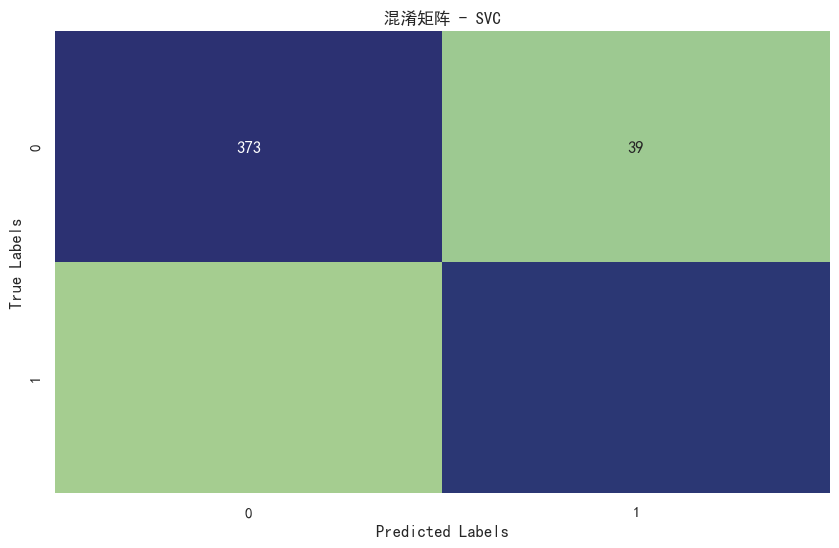


SVC模型得分: 91.52119700748129 



In [145]:
conf_matrix = confusion_matrix(y_test, svc_predicted)

plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='crest', cbar=False)
plt.title('混淆矩阵 - SVC')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

print("\nSVC模型得分:", svc_acc_score * 100, '\n')

### 5.9.ROC曲线

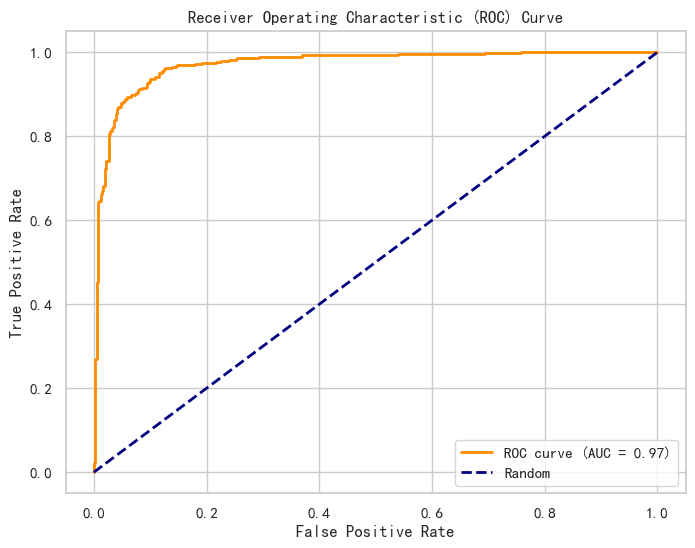

In [146]:
y_prob = best_svc_model.decision_function(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_prob)

roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


Another common metric is the Area Under the Curve, or AUC. This is a convenient way to capture the performance of a model in a single number, although it's not without certain issues. As a rule of thumb, an AUC can be classed as follows,

* 0.90 - 1.00 = ****excellent**** *
* 0.80 - 0.90 = ****good****
* 0.70 - 0.80 = ****fair****
* 0.60 - 0.70 = ****poor****
* 0.50 - 0.60 = ****fail****

### 5.10.交叉验证

In [147]:
cross_val_scores = cross_val_score(best_svc_model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)

print("\n交叉验证集得分:")
print(cross_val_scores)

average_cv_score = cross_val_scores.mean()
print("\n平均交叉验证集得分:", average_cv_score * 100)

std_cv_score = cross_val_scores.std()
print("标准差:", std_cv_score * 100)



交叉验证集得分:
[0.90031153 0.89859594 0.92043682 0.90483619 0.90639626]

平均交叉验证集得分: 90.6115347417635
标准差: 0.7707728804783651


### 5.11.学习曲线

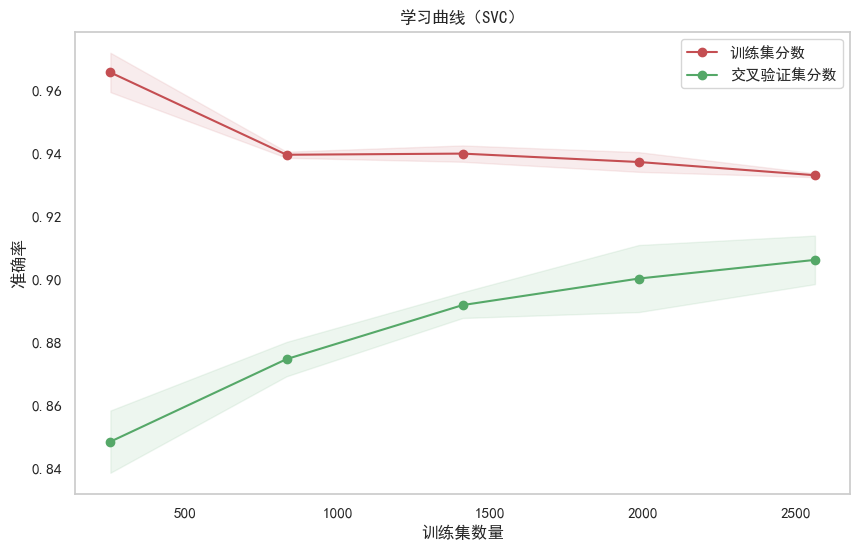

In [149]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure(figsize=(10, 6))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("训练集数量")
    plt.ylabel("准确率")

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='accuracy')

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="训练集分数")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="交叉验证集分数")

    plt.legend(loc="best")
    return plt

title = "学习曲线（SVC）"
plot_learning_curve(best_svc_model, title, X_train, y_train, cv=5, n_jobs=-1)
plt.show()
